# Modeling and extraction

The previous section presented techniques for identifying POIs. In this section, we will focus on techniques for extracting information from these POIs in order to create a statistical model and use it to mount an attack. As a reminder, profiled attack are divided in two phases: the (offline) training phase, during which an adversary builds the model based on $q_{p}$ profiling traces, and the (online) attack phase during which he uses the model in order to recover sensitive information from $q_a$ (fresh) attack traces. Here, *Modeling* refers to the training phase while *extraction* refers to the attack phase in itself. 

In the profiled attack setting, we rely on two different datasets. The first is the training dataset contains measurements acquired using random plaintext and keys that are used to build the models while limiting bias. This one is typically acquired by the adversary during the offline phase by using the same device that he aims to attack. The second is the online dataset, which contains the measurements obtained when the targeted device performs executions using a fixed key value that it aims to recover (e.g., in the context of a real application). 
For our exercises, we use fixed-key datasets for which we know the value of the key. These datasets are called validation datasets, and are used to evaluate the practical performances of attacks carried out using the models you will build. 

In this session, we will look at statistical modelling strategy, ranging from textbook (univariate Gaussian Template) to more advanced techniques (Multivariate Gaussian Template with dimensionality reduction).

## Gaussian Template Attack

Next, we will carry out one of the most popular attacks: a Gaussian template attack. As detailed in the book in Section 2.3.1, this technique involves modeling the physical measurements as random variables that follow a Gaussian distribution, which may differ for the different classes. More into the details, the Probability Density Function (PDF) of the leakage trace $\boldsymbol{l}$ measured conditioned to the fact that the intermediate value $z_i$ is manipulated can be expressed as:

$$\mathsf{f}(\boldsymbol{l}|z_i) = \frac{1}{(2\pi)^{\frac{\tau}{2}}\left|\boldsymbol{\Sigma}_{z_i}\right|} \cdot \mathsf{exp}\left( -\frac{1}{2}\left(\boldsymbol{l} - \boldsymbol{\mu}_{z_i}\right)^{\intercal} \cdot \boldsymbol{\Sigma}_{z_i}^{-1} \cdot \left( \boldsymbol{l} - \boldsymbol{\mu}_{z_i}\right)\right)$$

where $\mu_{z_i}$ and $\boldsymbol{\Sigma}_{z_i}$ are respectively the means and the covariance matrix. The challenge of the profiling phase is therefore to estimate these (unknown) parameters of these distributions, which can be done by computing the empirical means and convariances:

$$
\begin{eqnarray}
    \hat{\boldsymbol{\mu}}_{z_i} &=& \hat{\mathsf{E}}_{\frac{q_p}{256}}\left( \boldsymbol{L}(z_i)\right), \\
    \hat{\boldsymbol{\Sigma}}_{z_i} &=& \hat{\mathsf{E}}_{\frac{q_p}{256}}\left( \left( \boldsymbol{L}(z_i) - \hat{\boldsymbol{\mu}}_{z_i}\right) \cdot \left( \boldsymbol{L}(z_i) - \hat{\boldsymbol{\mu}}_{z_i}\right)^{\intercal} \right).
\end{eqnarray}
$$

### Univariate Gaussian Template Attack
To start simple, we will first focus on univariate gaussian templates. That is, we will only exploit a single POI when building the model associated to an intermediate variable. In the context of a univariate Gaussian distribution, the profilling phase boils down to estimating the distribution mean and variance, which can be approximated as:

$$
\begin{eqnarray}
\mathsf{f}(\boldsymbol{l}|z_i) \approx \hat{\mathsf{f}}(\boldsymbol{l}|z_i) &=& \mathcal{N}\left( \boldsymbol{l}| \hat{\mu}_{z_i}, \hat{\sigma}^2_{z_i} \right) \\
&=& \frac{1}{\hat{\sigma}_{z_i}\sqrt{2\pi}} \hspace{2mm}\exp\left( - \frac{\left( l - \hat{\mu}_{z_i}\right)^2}{2\hat{\sigma}_{z_i}^2}\right)
\end{eqnarray}
$$

#### Step 1: POI selection

As a first step, you have to identify the POI to use. While you could go back in the previous session in order to recover the one to by hand, we propose you to implement this selection automatically, by sorting the different time sample in a traces according to a decreasing order of SNR value. 

More practically, you have to implement the function `POI_selection_SNR`. We remind you that you've already seen how to compute the SNR using SCALib: for convinence, you can use the function `ref_snr_scalib` from `test_scale`. Its signature follows the same as the one you had to implement and its signature is written here as a reminder:

```python
def ref_snr_scalib(traces, classes, nclasses):    
    """
    traces: the traces on which to compute the SNR, organised as a numpy array of float of shape (ntraces, nsamples)
    classes: the variables classes for each trace, as an array of shape(ntraces, nvars).  
    nclasses: the amount of different classes.
    
    return: the SNR values computed for each var at every time samples, as a numpy array of shape (nvars, nb_samples)
    """
```
More practically, you have to implement the function `POI_selection_SNR`:

- *hint: First, compute the SNR, then sort the POI with [argsort](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html)*

In [1]:
from utils_scale.test_scale import ref_snr_scalib
import numpy as np

#TODO implement this
def POI_selection_SNR(traces, classes, nclasses):
    """
    SNR based POIs selection
    
    traces: the training traces, as an array of shape (ntraces, nsamples).
    classes: the label associated to each variables for every traces, as an array of shape  (ntraces, nvars)
    nclasses: the amount of different classes. 
    
    Returns: the ordered POIs for each variable, as an array of shape (nvars, nsamples). 
    More particularly, each row contains that index sorted in a decreasing SNR order (i.e., the first 
    element has the maximum SNR value). 
    """
    # TODO
    ###ANSWER_START
    snrs = ref_snr_scalib(traces, classes, nclasses)
    return np.flip(np.argsort(snrs,axis=1),axis=1)
    ###ANSWER_STOP

You can test you function next

In [2]:
from utils_scale import test_scale
test_scale.test_POI_selection_SNR(POI_selection_SNR)

Good job! Your implementation seems correct :)


In addition, the following script allows you to display the `npois` first POIs found when targeting the  `bindex`-th Sbox output .

POIs identified: [3386]


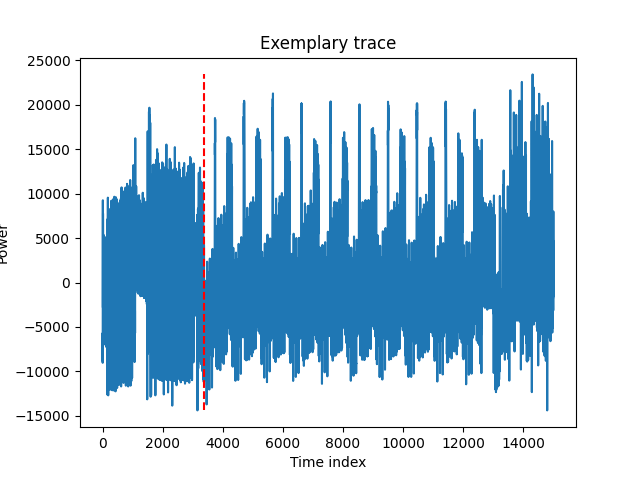

In [3]:
from utils_scale import utils_files, utils_aes, test_scale
%matplotlib widget
import matplotlib.pyplot as plt

# Load the dataset
ds = utils_files.load_dataset(utils_files.TRAINING_DS[0])

# TODO: change here
npois = 1
bindex = 0

# Compute intermediate states 
classes = utils_aes.Sbox[ds["pts"] ^ ds["ks"]]
# Compute the POIs based on your function
pois = POI_selection_SNR(ds['traces'], classes, 256)
# Display the selected POIS
test_scale.display_pois_TA(pois[bindex, :npois], ds['traces'][0])


#### Step 2: Model building (training phase)

As a second step, you have to compute $\hat{\mu}_{z_i}$ and $\hat{\sigma}_{z_i}$. At first, taking into account the small training data complexity, we invite you to implement a pooled variance estimation: that is, we consider that the noise distribution is the same for every classes. In such a situation, a single noise variance is computed (per variable), and used in the subsequent models (as described in Section 2.3.1 of the book).

More practically, you have to implement the function `univariate_gaussian_models`

In [4]:
import numpy as np
def univariate_gaussian_models(traces, classes, pois):
    """
    traces: the training traces, as an array of shape (ntraces, nsamples).
    classes: the label associated to each variables for every traces, as an array of shape  (ntraces, nvars)
    pois: the single POI kept for each variable, as an array of shape (nvars,)
    
    return: (us, ss), where `us` and `ss` are of shape (nvars, 256) and contain respectively 
    the mean and the standard deviation associated every classes of the different variables.
    """
    # TODO
    ###ANSWER_START
    # Allocate return value
    us = np.zeros([classes.shape[1],256])
    ss = np.zeros([classes.shape[1],256])
    
    # Iterate over every variables
    for si in range(classes.shape[1]):
        # Allocate memory squared traces accumulator (used for pooled variance computation)
        sum_sq_center_traces = 0

        # Iterate over all the possible bytes values
        for b in range(256):
            # Compute class mean
            us[si,b] = np.mean(traces[classes[:,si] == b, pois[si]])
            
            # Compute the centered traces
            ctraces = traces[classes[:,si] == b, pois[si]] - us[si,b]
            
            # Accumulate the squared centered traces
            sum_sq_center_traces += np.sum(np.square(ctraces),axis=0)
            
        # Second, compute the pooled variance
        ss[si,:] = np.sqrt((sum_sq_center_traces / (traces.shape[0]-1)))
    # Return
    return (us, ss)
    ###ANSWER_STOP


The following code snippet enables you to visualize the model you build in comparison to the empirical data used. In particular, you can choose which Sbox to target and the class to visualize with the parameters `bindex` and `vclass`. Check whether you model properly fit the data! 

In [5]:
from utils_scale import utils_files, utils_aes, test_scale

# Load the dataset
ds = utils_files.load_dataset(utils_files.TRAINING_DS[0])

# Compute intermediate states 
classes = utils_aes.Sbox[ds["pts"] ^ ds["ks"]]
# Compute the POIs based on your function
pois = POI_selection_SNR(ds['traces'], classes, 256)
# Compute the models
models_uni = univariate_gaussian_models(ds['traces'], classes, pois[:,0])

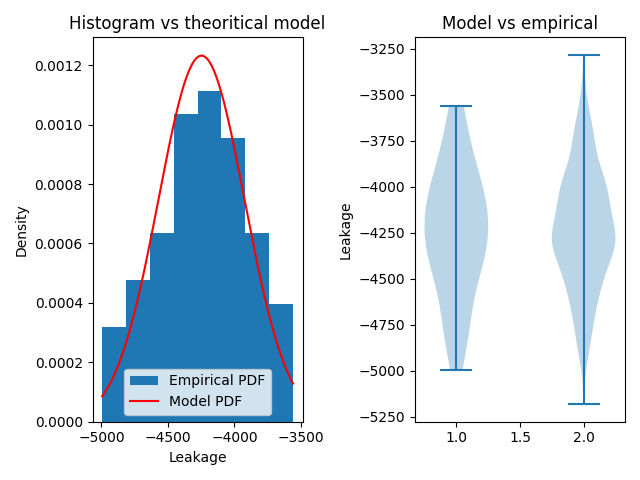

In [6]:
from utils_scale import utils_plot
%matplotlib widget
import matplotlib.pyplot as plt

# Display visually the model
# TODO: modify these
bindex = 0
vclass = 157

utils_plot.plot_empirical_vs_model_dist(ds, classes, pois, models_uni, bindex, vclass)

Besides, you can use the following piece of code to display the model PDF for multiple classes. Try to look at the distributiosn for different traces!

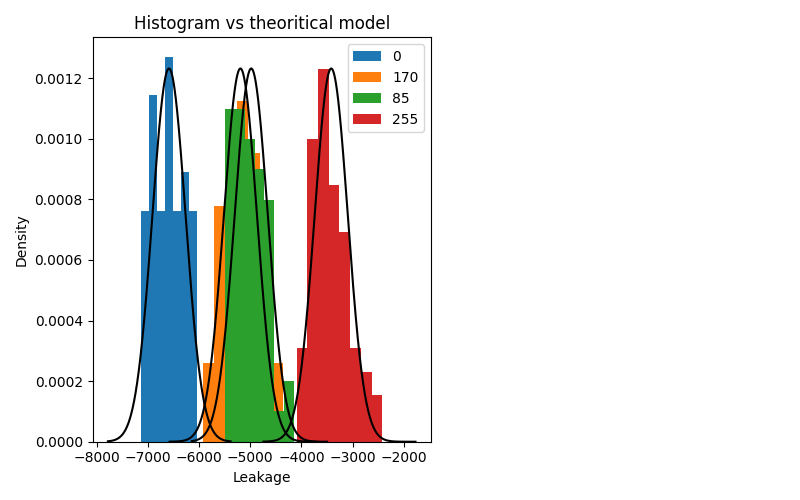

In [7]:
from utils_scale import utils_plot
%matplotlib widget
import matplotlib.pyplot as plt

# Display visually the model
bindex = 0
vclasses = [0,0b10101010, 0b01010101, 0xff]

utils_plot.plot_empirical_vs_model_dist_several(ds, classes, pois, models_uni, bindex, vclasses)

#### Step 4: Exploiting the model (online attack phase)

Once these models (also known as templates) are created, it remains to see how they can lead to practical attacks. During the extraction phase, an adversary typically has access to a target device with a fixed key that he seeks to retrieve. To this end, he obtains a set of fresh measurements for different executions and can perform a maximum likelihood attack based on these measurements and the models he has constructed. 

More precisely, for each trace, we can estimate the probability that yhr target variable belongs to a specific class. When targeting the output of the Sbox, the intermediate value $z_i$ used above can be expressed as $z_i=\mathsf{Sbox}(p_i \oplus k_i)$ and the aformentionned probability can be expressed as follows thanks to [Bayes' law](https://en.wikipedia.org/wiki/Bayes%27_theorem#For_continuous_random_variables)

$$
\begin{eqnarray}
\check{k}_i &=& \underset{k^*_i}{\mathsf{argmax}}\hspace{2mm}\hat{\mathsf{Pr}}\left( k_{i}^* | p_i, \boldsymbol{l}\right) \\
            &=& \underset{k^*_i}{\mathsf{argmax}}\hspace{2mm}\frac{\hat{\mathsf{f}}\left( \boldsymbol{l} | \mathsf{Sbox}\left(p_i \oplus k_{i}^*\right) \right) \cdot \mathsf{Pr}(k^*_i)}{\sum^{255}_{k'_i=0} \hat{\mathsf{f}}\left( \boldsymbol{l}|\mathsf{Sbox}\left(p_i \oplus k'_{i}\right)\right) \cdot \mathsf{Pr}\left( k'_i \right)}
\end{eqnarray}
$$

where $\mathsf{Pr}(x)$ is a shortcut for $\mathsf{Pr}\left(X =x \right)$ for conciseness.

Again, we will advance step by step here. To simplify your life, we've already provided you with the following function, which calculates the value of the Gaussian probability density function for fixed parameters. (Note, you can import this function from `utils_ta`)

In [8]:
def gaussian_pdf(xs, mean, std):
    """
    Gaussian pdf

    xs: the point for which we wish to compute, as an array of shape (nvar, )
    mean: the mean of the distribution, as a float
    std: the standard deviation of the distribution, as a float

    """
    coef = 1/(std*np.sqrt((2*np.pi)))
    return coef * np.exp(-(xs-mean)**2 / (2*(std**2)))

Next, you have to implement the first r `log2Pr_class` that compute the probabilities of every class of the targeted intermediate variable given the traces. That is, for each traces, you have to compute 256 different probabilities. This is done in practice by applying [Bayes' law](https://en.wikipedia.org/wiki/Bayes%27_theorem#For_continuous_random_variables) using the models built during the profiling phase.

In [9]:
def log2Pr_class(traces, models):
    """ 
    Compute the conditional probability of the classs given the leakages by applying Bayes law.

    traces: the univariate leakage, as an array of shape (ntraces,nvars)
    models: (us, ss) such as 
        us: the models means for each class, as an array of shape (nvars, nclasses)
        ss: the models stds for each class, as an array of shape (nvars, nclasses)

    Returns: an array of shape (nvars, ntraces, nclasses),
    containing for every variables, for every traces, the log2 probability associated to each class, 
    """
    ###ANSWER_START
    # Allocate log-probabilities matrix
    probas = np.zeros([models[0].shape[0],traces.shape[0],models[0].shape[1]])
    for vi, (vtrs, vus, vss) in enumerate(zip(traces.T, models[0], models[1])):
        # Compute the raw density values
        for ci in range(models[0].shape[1]):
            probas[vi, :, ci] = gaussian_pdf(vtrs, vus[ci], vss[ci])
        # Normalize
        probas[vi] = probas[vi] / np.sum(probas[vi],axis=1)[:,np.newaxis]
    return np.log2(probas)
    ###ANSWER_STOP



Now, given the probabilities computed in the previous step, you have to implement the function `maximum_likelihood` that compute the probabilities associated to each subkey.

In [10]:
from utils_scale.utils_aes import Sbox
def maximum_likelihood(pts, log2pr_sb):
    """
    pts: plaintext, as an array of shape (ntraces, nvars)
    log2pr: the log proba of the Sbox class, as an array of shape (nvars, ntraces, nclasses)

    returns: the probas associated to each subkey bytes, as an array of shape (nvars, nclasses)
    """
    ###ANSWER_START
    lprobas = np.zeros([pts.shape[1], log2pr_sb.shape[2]])
    for vi, (vpt, logpr) in enumerate(zip(pts.T, log2pr_sb)):
        for ki in range(log2pr_sb.shape[2]):
            ist = Sbox[vpt ^ ki]
            lprobas[vi, ki] = np.sum(logpr[np.arange(pts.shape[0]), ist])
    # Normalization
    # Scaling to avoid numerical instabilities
    max_log = np.max(lprobas,axis=1)[:,np.newaxis]
    lprobas = lprobas - max_log 

    # Compute the sum of probas for each key guess
    sum_probas = np.sum(np.exp2(lprobas),axis=1)[:,np.newaxis]
    
    # Compute the normalized probabilities
    return np.exp2(lprobas - np.log2(sum_probas))
    ###ANSWER_STOP

Finally, you can implement the attack by mixing together the two previous functions!

In [11]:
def univariate_TA(traces, pts, pois, models):
    """
    traces: the training traces, as an array of shape (ntraces, nsamples).
    pts: the plaintext used, as an array of shape (ntraces, nvars)
    pois: the list of pois to used, as an array of shape (nvars, )
    models: (us, ss) such as 
        us: the models means for each class, as an array of shape (nvars, nclasses)
        ss: the models stds for each class, as an array of shape (nvars, nclasses)

    return: the probabilities associated to each subkey, as an array of shape (nvar, nclasses)
    """
    ###ANSWER_START
    # First, keep only the POIs for each vars
    traces_poi = traces[:, pois]
    # Second, compute the logprobs based on the models
    log2pr_sb = log2Pr_class(traces_poi, models)
    # Finally, perform the ML
    lprobas = maximum_likelihood(pts, log2pr_sb)
    # return lprobas
    return lprobas
    ###ANSWER_STOP
    

Try to run the attack with the following code snippet. How does the attack complexity compare with the one you obtained with the CPA? 

In [12]:
from utils_scale import utils_files, utils_aes, test_scale

# Load the dataset
ds = utils_files.load_dataset(utils_files.VALIDATION_DS[0], seed_shuffle=0)

# Amount of trace to used for the online attack phase
q_a = 25

# Performs the attack
probas = univariate_TA(ds['traces'][:q_a], ds['pts'][:q_a], np.array([pois[:,0]]), models_uni )
kguess = np.argmax(probas,axis=1)

for kg, kc in zip(kguess, ds['ks'][0]):
    print("Guessed {} (must be {}) --> {}".format(kg, kc, "SUCCESS" if kg == kc else "FAIL"))

Guessed 66 (must be 66) --> SUCCESS
Guessed 26 (must be 26) --> SUCCESS
Guessed 190 (must be 190) --> SUCCESS
Guessed 63 (must be 127) --> FAIL
Guessed 152 (must be 152) --> SUCCESS
Guessed 103 (must be 103) --> SUCCESS
Guessed 41 (must be 41) --> SUCCESS
Guessed 47 (must be 47) --> SUCCESS
Guessed 14 (must be 14) --> SUCCESS
Guessed 30 (must be 30) --> SUCCESS
Guessed 175 (must be 175) --> SUCCESS
Guessed 133 (must be 133) --> SUCCESS
Guessed 61 (must be 61) --> SUCCESS
Guessed 48 (must be 48) --> SUCCESS
Guessed 12 (must be 12) --> SUCCESS
Guessed 130 (must be 130) --> SUCCESS


The following code snippet allows you to evaluate the attack's performance in a more general and detailed context. In particular, it performs attacks against the 5 validation datasets, with different attack complexities. Each subplot represents the evolution of the probability of each subkey as a function of attack complexity (with the correct value in black and the others in gray). What do you observe? Is the attack equally effective against all subkeys? 

Byte 0: 6 traces required
Byte 1: 10 traces required
Byte 2: 18 traces required
Byte 3: 34 traces required
Byte 4: 15 traces required
Byte 5: 11 traces required
Byte 6: 12 traces required
Byte 7: 12 traces required
Byte 8: 5 traces required
Byte 9: 11 traces required
Byte 10: 24 traces required
Byte 11: 9 traces required
Byte 12: 6 traces required
Byte 13: 10 traces required
Byte 14: 9 traces required
Byte 15: 6 traces required
(1, 35, 16, 256)


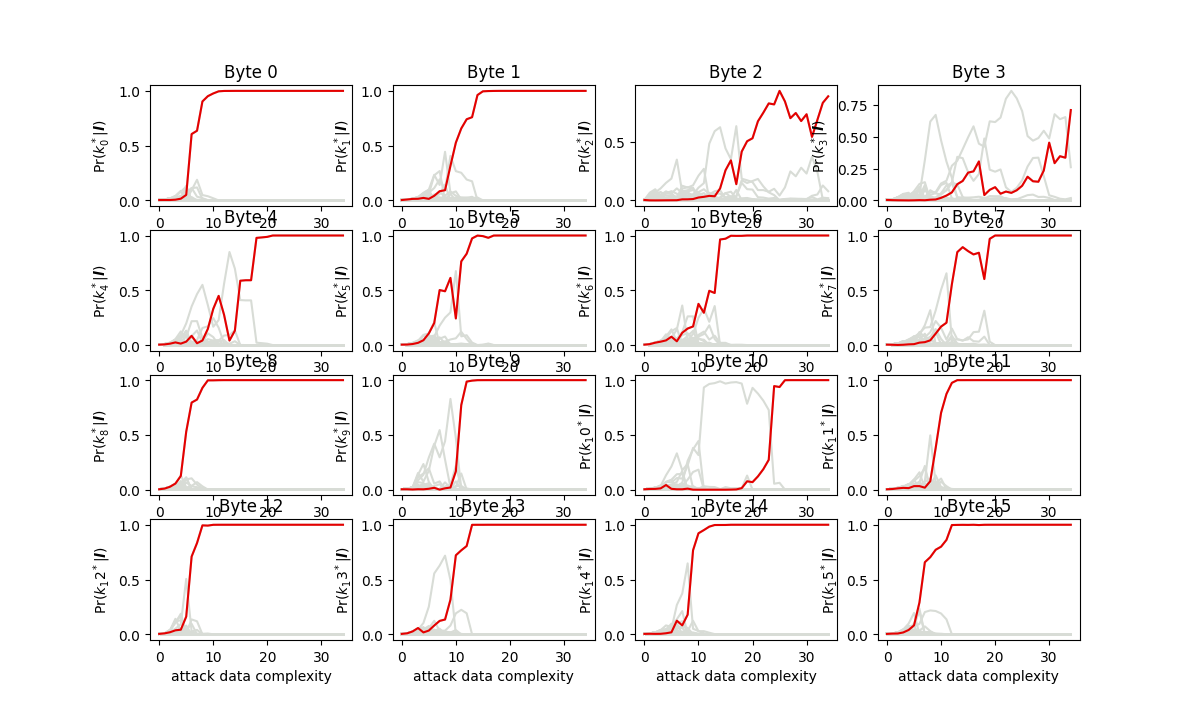

In [13]:
from utils_scale import utils_ta, utils_files

# Dataset used for the training
ds_train = utils_files.TRAINING_DS[0]

# Datasets on which perform the attack for comparions
ds_atcks = [utils_files.VALIDATION_DS[0]]

# Profilling complexity
qp = 16384

# Attack complexities
qas = range(35)

v = utils_ta.explore_TA_univariate(ds_train, ds_atcks, qp, qas)
utils_ta.display_explore_TA_univariate_result(v)


## Improving the Template Attack with a more advanced training phase
As you no doubt thought during the detection and mapping session, using only one point of interest can be sub-optimal given the number of points of appearing present in the traces. You were right!

As described in Sections 2.3.1 and 2.3.2 of the book, a straightforward way to improve attacks to create multivariate models using multiple POIs in the traces and using dimensionality reduction techniques (e.g., using LDA or PCA). This section looks in more detail at this type of technique and enables you to manipulate them in order to observe the different trades-offs in terms of complexity (profiling and attack) that they involve.



### First step: POI selection
The first relevant question to ask is: which POIs should I choose? 

Let's consider SNR as a detection method. Naively, we would like to take the POIs as the time index sorted in descending order of SNR value. But is it a good strategy? Put in another way, are all the POIs equally relevant when considered simultaneously? We take a closer look at this question in the following exercise.

The following code snippet is re-using what you already saw in order to display the SNR associated to a specific Sbox output. Besides, it lets you choose several POIs (by adding them to `pois`). This display allows you to check exactly which SNR value corresponds to the selected POI, as well as the visual position in the trace. Additionnally, a second cell allows to display the scatter plot between the leakage values corresponding to both POIs. 

We ask you to use this code in order to answer the following questions (we consider `bindex`=0 first):

- Lets assume at first that you first POI is 3348. Considering the strategy maximizing the SNR described above. What would be the second POI? 
- Add it to the POI pool and plot the scatter plot. What do you observe? How do you explain it? 
- How many distinct SNR peaks (even small) do you observe?
- Try to use POIs from different peaks and plot the scatter plots. What do you observe? What does it suggest?
- Is it the same for other Sboxes?


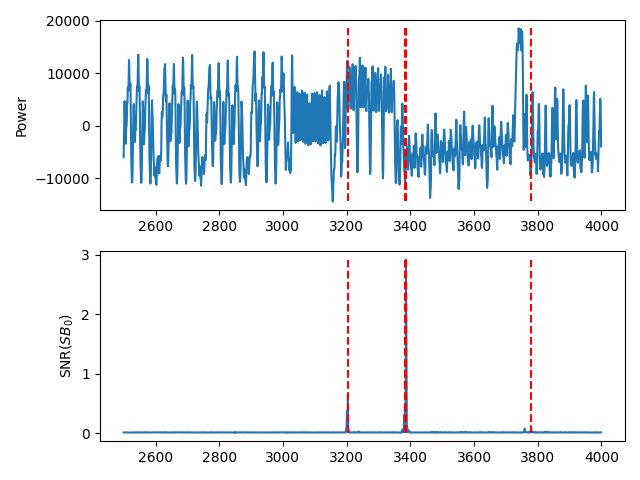

In [14]:
from utils_scale import utils_files, utils_aes
%matplotlib widget
import matplotlib.pyplot as plt
# Cropping window for display
start, end =[2500,4000]

# Selection of target
# TODO: you can modify here
bindex = 0

# TODO modify here
pois = [3606, 3740, 3301]

###ANSWER_START
pois = [3386, 3387, 3204, 3383, 3779]
###ANSWER_STOP

# Load dataset, compute SNR for Sbox output
ds = utils_files.load_dataset(utils_files.TRAINING_DS[0])
classes = utils_aes.Sbox[ds["pts"] ^ ds["ks"]]
snrs = ref_snr_scalib(ds['traces'], classes, 256)

# Plot the result 
f= plt.figure()
xs = range(start,end)
ax0 = f.add_subplot(2,1,1)
ax0.set_ylabel("Power")
ax1 = f.add_subplot(2,1,2)
ax1.set_ylabel(r'SNR($SB_{{{}}})$'.format(bindex))
ax0.plot(xs, ds['traces'][0,start:end])
ax1.plot(xs, snrs[bindex,start:end])
for poi in pois:
    ax0.vlines(poi, ymin=min(ds['traces'][0,start:end]), ymax=max(ds['traces'][0,start:end]), linestyle="dashed", color="red")
    ax1.vlines(poi, ymin=min(snrs[bindex,start:end]), ymax=max(snrs[bindex,start:end]), linestyle="dashed",color="red")
f.tight_layout()
plt.show()

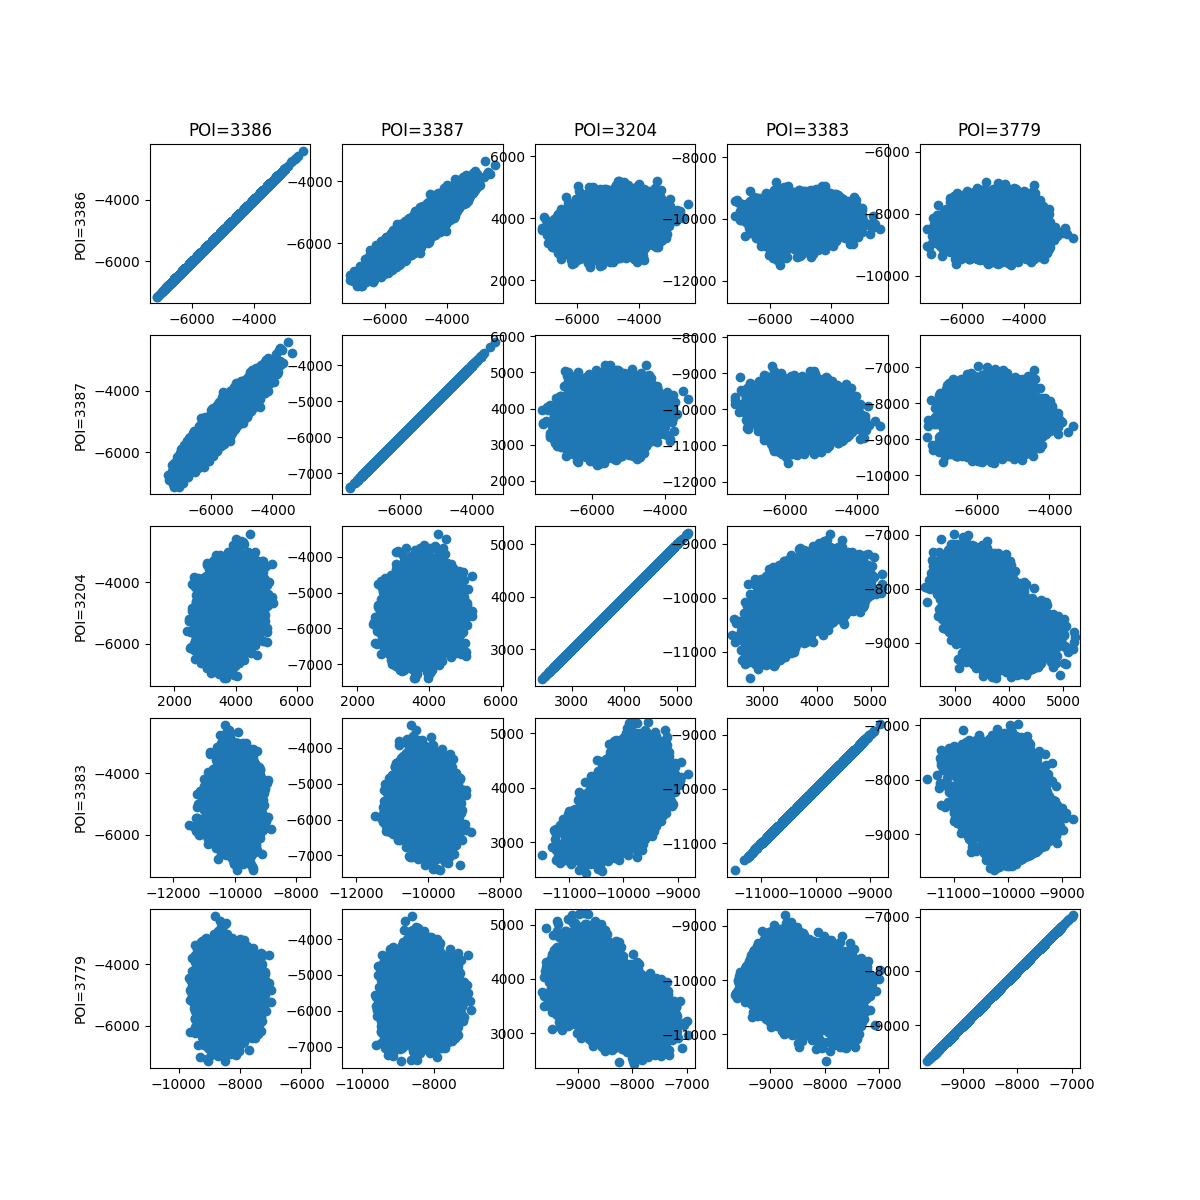

In [15]:
# Plot the scatter between the leakages values at both POIs
f, axes = plt.subplots(len(pois),len(pois))
f.set_figheight(12)
f.set_figwidth(12)
if len(pois)==1:
    axes=np.array([[axes]])
for i, p0 in enumerate(pois):
    for j, p1 in enumerate(pois):
        axes[i,j].scatter(ds['traces'][:,p0],ds['traces'][:,p1])
        axes[i,j].axis('equal')
        if j==0:
            axes[i,j].set_ylabel(f'POI={p0}')
        if i==0:
            axes[i,j].set_title(f'POI={p1}')
plt.show()


## Multivariate Gaussian Template with dimensionality reduction
Next, you will deal with a more advanced model: the multivariate Gaussian Template. As already mentioned, we will use multiple POIs in order to extract more information. Before fitting the (multivariate) Gaussian parameters, we will apply a pre-processing step in order to reduce the dimension that will be considered in the distribution. As described more into the detail in Sections 2.3.1 and 2.3.2 of the book, this step avoids the need for profiling complexities that are difficult to achieve in practice (especially in the case considered in the training where the complexity is limited).

More practically, we will start using Linear Discriminant Analysis (LDA). Instead of implementing all the computation by yourself, we invite you to rather rely on the SCALib library that already implements useful tools: the [LdaAcc](https://scalib.readthedocs.io/en/stable/source/api/scalib.modeling.LdaAcc.html#scalib-modeling-ldaacc) and the [Lda](https://scalib.readthedocs.io/en/stable/source/api/scalib.modeling.Lda.html#scalib-modeling-lda) objects. 

Your first task is to implement the function `multivariate_gaussian_models` that implements the profiling phase using SCALib tools.

- *hint: the implementation of the function is **very** similar to LdaAcc example fomr SCALib's documentation*
- *hint2: you may require to following function for formatting purpose: [ndarray.tolist](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.tolist.html#numpy-ndarray-tolist), [ndarray.astype](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html)*


In [16]:
from scalib.modeling import Lda, LdaAcc

#TODO: implement this function
def multivariate_gaussian_models(traces, classes, pois, ndim):
    """
    Multivariate Gaussian template with dimensionality reduction using LDA.
    
    We consider 256 classes for each variables.
    
    traces: the training traces, as an array of shape (ntraces, nsamples).
    classes: the label associated to each variables for every traces, as an array of shape  (ntraces, nvars)
    pois: the single POI kept for each variable, as an array of shape (nvars, npois)
    ndim: number of dimensions to keep after dimensionality reduction for each variable, as an int.
    
    return: an solved 'Lda' instance for 'ndim' dimension.
    """
    ###ANSWER_START
    lda_acc = LdaAcc(nc=256, pois=pois.tolist())
    lda_acc.fit_u(traces.astype(np.int16), classes.astype(np.uint16))
    return Lda(lda_acc, p=ndim)
    ###ANSWER_STOP

Second, you have to adapt your implementation of `univariate_TA` in order to use your multivariate models. You have to implement the following function

- *hint: The implementation is **very** similar to the funtion `univariate_TA`.Go get some inspiration from the solution notebook if you are lost!*
- *hint2: Notice that the model are embedding the POIs. Thanks to SCALib API, these are not required anymore as an argument.*

In [17]:
def multivariate_LDA_TA(traces, pts, models):
    """
    traces: the training traces, as an array of shape (ntraces, nsamples).
    pts: the plaintext used, as an array of shape (ntraces, nvars)
    models: the 'Lda' instance build with 'multivariate_gaussian_models'

    return: the probabilities associated to each subkey, as an array of shape (nvar, nclasses)
    """
    ###ANSWER_START
    # First, we compute the logprobs based on the models
    pr_sb = models.predict_proba(traces.astype(np.int16))
    # Finally, perform the ML
    lprobas = maximum_likelihood(pts, np.log2(pr_sb))
    # return lprobas
    return lprobas
    ###ANSWER_STOP

Let's try to analyze the attack complexity achieved with this new (more complex) model. For this purpose, here is a piece of code that runs attacks against the different validation dataset (similarly to what was done for the univariate TA). At this stage, we still select the POIs as the time samples sorted in a decreasing SNR value. Try to play a bit with the different parameters so see how they affect the attack capabilities:

- What is the impact of increasing the amount of POIs? Can you increase it as much as you like without affecting the results of the attack?
- Same question for the amount if dimnension in the linear subspace.
- What is the best attack you can reach?

Byte 0: 2 traces required
Byte 1: 2 traces required
Byte 2: 2 traces required
Byte 3: 1 traces required
Byte 4: 4 traces required
Byte 5: 1 traces required
Byte 6: 4 traces required
Byte 7: 2 traces required
Byte 8: 1 traces required
Byte 9: 3 traces required
Byte 10: 6 traces required
Byte 11: 3 traces required
Byte 12: 2 traces required
Byte 13: 2 traces required
Byte 14: 2 traces required
Byte 15: 1 traces required
(1, 35, 16, 256)


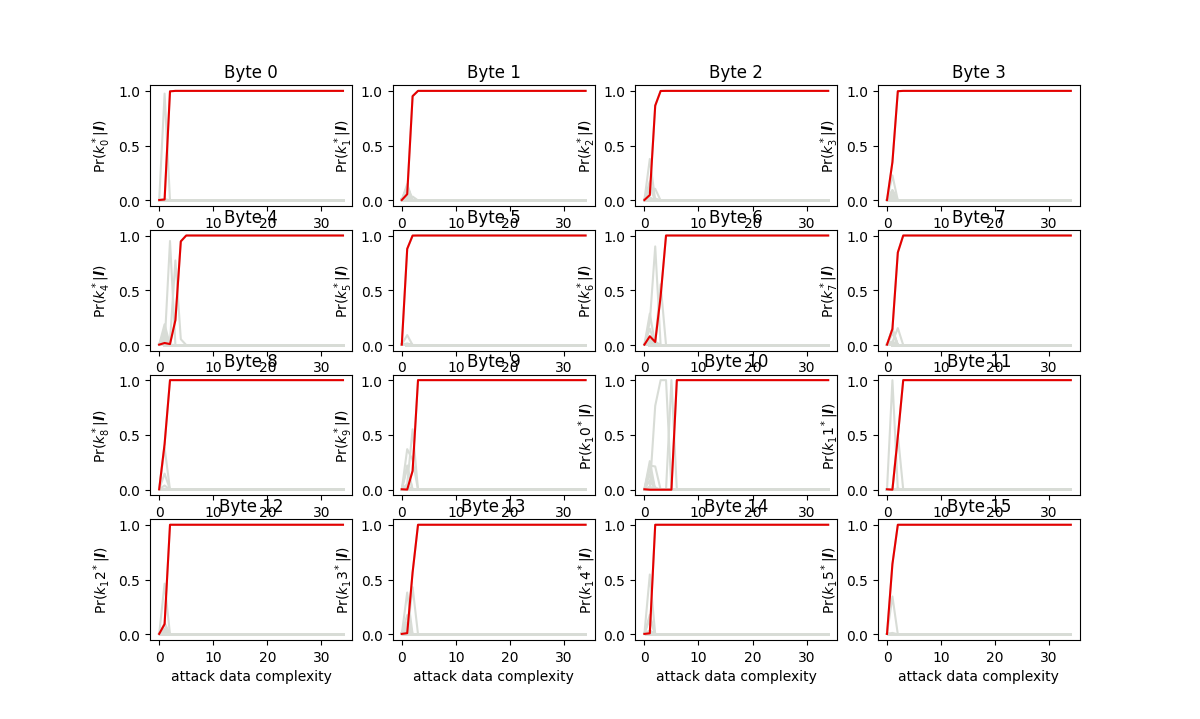

In [25]:
from utils_scale import utils_ta, utils_files

# Dataset used for the training
ds_train = utils_files.TRAINING_DS[0]

# Datasets on which perform the attack for comparions
ds_atcks = [utils_files.VALIDATION_DS[0]]

# Profilling complexity
qp = 16384

# Attack complexities
qas = range(0,35)

# TODO: modify here
npois = 1
ndim = 1

###ANSWER_START
npois = 104 # not above 103, above Byte10 starts to fail
ndim = 3 # For 104 npois, above 3 makes byte 10 failing
###ANSWER_STOP



v = utils_ta.explore_TA_multivariate(ds_train, ds_atcks, qp, qas, npois, ndim)
utils_ta.display_explore_TA_univariate_result(v)


## A deeper investigation about the SNR based POI selection.
For the last exercise, we suggest you take a closer look at POI selection. In particular, we propose to investigate whether a selection of POIs different from chosing the time index that have a decreasing SNR value can lead to better performance. To do this, the following code snippet lets you attack a subkey by selecting POIs by hand. The results obtained are compared with an attack using SNR-based selection, using the same number of POIs and the same number of projected dimensions.

- *hint: try to use POI that are non redundant*
- *hint2: The byte index 15 is of particular interest...*

In [19]:
from utils_scale import utils_files, utils_aes

dstrain = utils_files.load_dataset(utils_files.TRAINING_DS[0])
classes = utils_aes.Sbox[dstrain["pts"] ^ dstrain["ks"]]
pois_snr = POI_selection_SNR(dstrain['traces'], classes, 256)

# This can be usefull to have a look at how the SNR is selecting the POIs
amount_poi_plotted=10
for i in range(16):
    print(f'SNR POIs class {i}: {pois_snr[i,:amount_poi_plotted]}')

SNR POIs class 0: [3386 3387 3388 3204 3383 3201 3385 3381 3202 3384]
SNR POIs class 1: [3479 3210 3213 3478 3738 3475 3737 3473 4089 4090]
SNR POIs class 2: [3565 3219 3567 3568 3741 3740 3742 3221 3562 3569]
SNR POIs class 3: [3228 3658 3229 3227 3654 3657 3226 3656 3652 3651]
SNR POIs class 4: [3407 3408 3409 3406 3244 3241 3404 3402 3240 3242]
SNR POIs class 5: [3496 3497 3498 3250 3494 3732 3493 3731 3253 3733]
SNR POIs class 6: [3586 3585 3587 3588 3259 3583 3744 3745 3261 3746]
SNR POIs class 7: [3675 3676 3268 3677 3267 3269 3672 3674 3266 3673]
SNR POIs class 8: [3428 3427 3429 3430 3281 3284 3425 3423 3951 3280]
SNR POIs class 9: [3517 3518 3519 3290 3734 3514 3516 3515 3293 3735]
SNR POIs class 10: [3606 3607 3608 3604 3740 3301 3299 3738 3609 3741]
SNR POIs class 11: [3696 3697 3308 3698 3749 3695 3307 3309 3747 3748]
SNR POIs class 12: [3448 3449 3450 3321 3446 3451 3324 3445 3444 3320]
SNR POIs class 13: [3538 3539 3330 3540 3736 3537 3535 3737 3735 3332]
SNR POIs class 1

Tipping points for DATASET 0
-SNR based: 8 traces.
-Hand chosen: 7 traces.


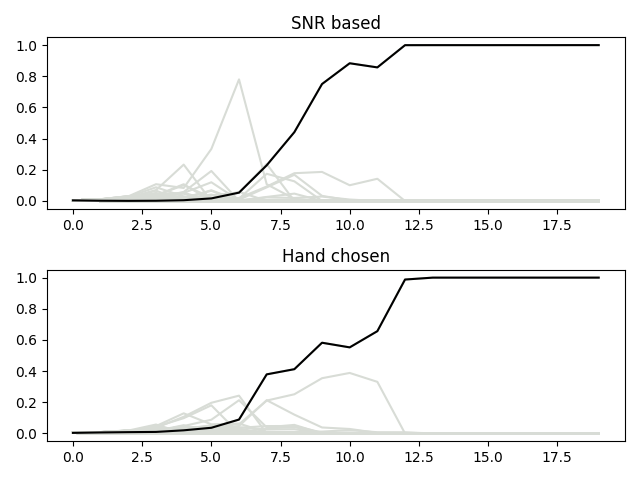

In [30]:
import matplotlib.pyplot as plt
from utils_scale import utils_ta

#### TODO edit here
bindex = 15
my_pois = [3717]
ndim = 1

###ANSWER_START
my_pois = [3717, 3348]
###ANSWER_STOP

# Validation dataset used
ds_index = 0


############# Dont modify from here ;)
qas = range(20)
model_snr = multivariate_gaussian_models(dstrain['traces'], classes[:,bindex][:,np.newaxis], pois_snr[bindex,:len(my_pois)][np.newaxis,:], ndim)
model_mypois = multivariate_gaussian_models(dstrain['traces'], classes[:,bindex][:,np.newaxis], np.array([my_pois]), ndim)

ds_atcks = [utils_files.VALIDATION_DS[ds_index]]
prs_snr = np.zeros([len(ds_atcks),len(qas),256])
prs_mypois = np.zeros([len(ds_atcks),len(qas),256])
kc = np.zeros(len(ds_atcks),dtype=int)
for dai,da in enumerate(ds_atcks):
    dsa = utils_files.load_dataset(da, seed_shuffle=0)
    kc[dai] = dsa["ks"][0,bindex]
    for qai, qa in enumerate(qas):
        prs_snr[dai, qai] = multivariate_LDA_TA(dsa['traces'][:qa], dsa['pts'][:qa,bindex][:,np.newaxis], model_snr)
        prs_mypois[dai, qai] = multivariate_LDA_TA(dsa['traces'][:qa], dsa['pts'][:qa,bindex][:,np.newaxis], model_mypois)


f, axes = plt.subplots(2,1)
axes[0].set_title("SNR based")
axes[1].set_title("Hand chosen")
for i in range(len(ds_atcks)):
    print(f'Tipping points for DATASET {ds_index}')
    print("-SNR based: {} traces.".format(utils_ta.tipping_point(prs_snr[i], kc[i])))
    print("-Hand chosen: {} traces.".format(utils_ta.tipping_point(prs_mypois[i], kc[i])))
    axes[0].plot(qas, prs_snr[i], color="xkcd:light grey")
    axes[1].plot(qas, prs_mypois[i], color="xkcd:light grey")

for i in range(len(ds_atcks)):
    axes[0].plot(qas, prs_snr[i,:,kc[i]], color="black")
    axes[1].plot(qas, prs_mypois[i,:,kc[i]], color="black")
f.tight_layout()
